### Airbnb Popularity Prediction

A regression problem of predicting reviews_per_month, as a proxy for the popularity of the listing with New York City Airbnb listings from 2019 dataset. Airbnb could use this sort of model to predict how popular future listings might be before they are posted, perhaps to help guide hosts create more appealing listings. In reality they might instead use something like vacancy rate or average rating as their target, but we do not have that available here.

#### Importing Libraries

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge

from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
)

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LassoCV
from xgboost import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from catboost import CatBoostRegressor

%matplotlib inline

#### Data Preprocessing

In [2]:
airbnb_df = pd.read_csv("AB_NYC_2019.csv")
airbnb_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [4]:
# Removing rows where 'reviews_per_month' value is NA

airbnb_df = airbnb_df[airbnb_df['reviews_per_month'].notna()]

In [5]:
# Handling the NA Values present in `name` column

airbnb_df = airbnb_df[airbnb_df['name'].notna()]

In [6]:
# Changing few feature names to more readable and informative names

airbnb_df = airbnb_df.rename(columns={'name': 'listing_name', 'availability_365':'num_days_available', 'price' : 'listing_price'})

In [7]:
# We now have a total of 38837 rows and none of the columns have any NA values (except host_name which we will be dropping)

airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38837 entries, 0 to 48852
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              38837 non-null  int64  
 1   listing_name                    38837 non-null  object 
 2   host_id                         38837 non-null  int64  
 3   host_name                       38821 non-null  object 
 4   neighbourhood_group             38837 non-null  object 
 5   neighbourhood                   38837 non-null  object 
 6   latitude                        38837 non-null  float64
 7   longitude                       38837 non-null  float64
 8   room_type                       38837 non-null  object 
 9   listing_price                   38837 non-null  int64  
 10  minimum_nights                  38837 non-null  int64  
 11  number_of_reviews               38837 non-null  int64  
 12  last_review                     

#### Data Splitting

In [8]:
train_df, test_df = train_test_split(airbnb_df, test_size=0.3, random_state=123)

In [9]:
train_df.shape

(27185, 16)

In [10]:
test_df.shape

(11652, 16)

### Exploratory Data Analysis (EDA)

In [11]:
# Summary Statistics

train_df.describe(include = 'all')

,id,listing_name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,listing_price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,num_days_available
count,2.718500e+04,27185,2.718500e+04,27179,27185,27185,27185.000000,27185.000000,27185,27185.000000,27185.000000,27185.000000,27185,27185.000000,27185.00000,27185.000000
unique,NaN,26893,NaN,7974,5,217,NaN,NaN,3,NaN,NaN,NaN,1689,NaN,NaN,NaN
top,NaN,Home away from home,NaN,Michael,Manhattan,Williamsburg,NaN,NaN,Entire home/apt,NaN,NaN,NaN,2019-06-23,NaN,NaN,NaN
freq,NaN,10,NaN,230,11566,2226,NaN,NaN,14215,NaN,NaN,NaN,979,NaN,NaN,NaN
mean,1.796071e+07,NaN,6.369945e+07,NaN,NaN,NaN,40.728101,-73.950882,NaN,141.340887,5.888799,29.458819,NaN,1.370237,5.05389,115.108736
std,1.070756e+07,NaN,7.568369e+07,NaN,NaN,NaN,0.054997,0.046970,NaN,189.356695,16.826136,48.264551,NaN,1.690512,25.85398,129.422655
min,2.539000e+03,NaN,2.787000e+03,NaN,NaN,NaN,40.506410,-74.239860,NaN,0.000000,1.000000,1.000000,NaN,0.010000,1.00000,0.000000
25%,8.549497e+06,NaN,6.947307e+06,NaN,NaN,NaN,40.688630,-73.982310,NaN,69.000000,1.000000,3.000000,NaN,0.190000,1.00000,0.000000
50%,1.866950e+07,NaN,2.784491e+07,NaN,NaN,NaN,40.721770,-73.954670,NaN,102.000000,2.000000,10.000000,NaN,0.710000,1.00000,56.000000
75%,2.746893e+07,NaN,1.007843e+08,NaN,NaN,NaN,40.763010,-73.934770,NaN,170.000000,4.000000,34.000000,NaN,2.000000,2.00000,230.000000


**Reasoning**

As we can see from the Summary statistics above, the **mean** of all the numeric columns have a large variation so it is probably a good idea to apply the StandardScaler transformation on the numeric columns.
Also, in the `listing_name` column above we can see that there are many **unique** values so it might be a good idea to apply Count Vectorizer transformation on that column.

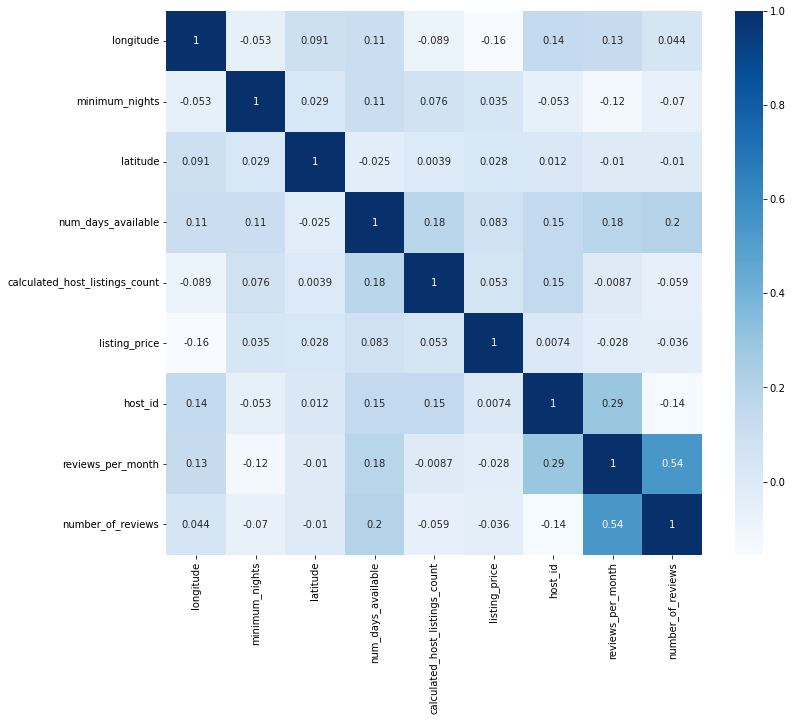

In [12]:
# Correlation of different features in our dataset

features = ['longitude',
 'minimum_nights',
 'latitude',
 'num_days_available',
 'calculated_host_listings_count',
 'listing_price',
 'host_id',
'reviews_per_month',
'number_of_reviews']

cor = train_df[features].corr()
cor

import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

**Reasoning**

From the correlation plot above, we can see that the columns `longitude`, `host_id` and `num_days_available` are positively correlated to our target column `reviews_per_month`. The column `calculated_host_listings_count` has a small and negative correlation to our target column. The column `minimum_nights` has a comparatively small magnitude and negative correlation to the target column. Based on the above observations, we can see that the column `number_of_reviews` is strongly correlated to our target column and it would not be fair to consider that column because in usual deployment scenraios, we don't have access to the number of reviews of an airbnb and are expected to find the reviews_per_month without those details.

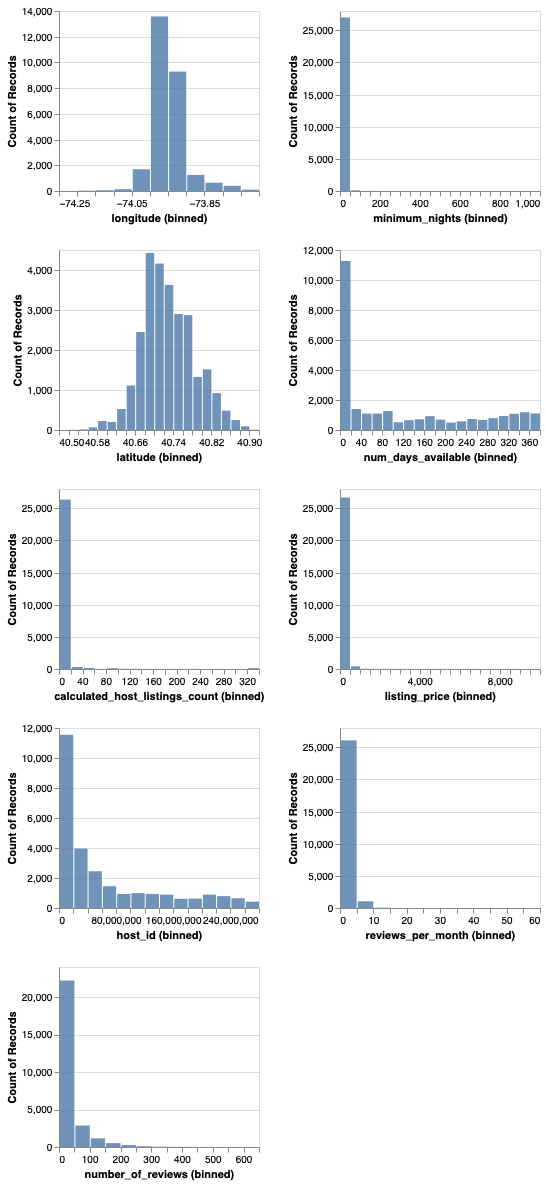

In [13]:
# Visualization of different numeric features using histograms

import altair as alt
from altair_data_server import data_server

alt.data_transformers.enable("data_server")
alt.renderers.enable('mimetype')

features = ['longitude',
 'minimum_nights',
 'latitude',
 'num_days_available',
 'calculated_host_listings_count',
 'listing_price',
 'host_id',
'reviews_per_month',
'number_of_reviews']

features_plot = alt.Chart(train_df).mark_bar(opacity = 0.8).encode(
    x = alt.X(alt.repeat(), type="quantitative", bin = alt.Bin(maxbins=25)),
    y = "count()").properties(width = 200, height = 180).repeat(repeat = features, columns =2)
features_plot

**Reasoning**

From the plots above, we can see that most of the features are skewed and hence we would need to scale all the features to be able to use them as part of our model.

**Analysis of EDA**

As per our EDA, we can see that there are many numeric columns that need to be scaled, so we can apply StandardScaler() transformation on those columns. We also can see that there are many unique values of `listing_name`, so it makes sense to apply CountVectorizer transformation on it. Also, as discussed above we would be dropping `number_of_reviews` as it does not make sense to have that data since that column would never be available to us in real world. We would also be dropping columns like `id` and `host_name` as these columns would not add any value in our predictions.

#### Feature Engineering

In [15]:
# Creating a new feature called last_review_interval

import datetime

train_df["last_review"] = pd.to_datetime(train_df.last_review)
train_df["last_review_interval"] = ((datetime.datetime(2019,12,31) - train_df.last_review)/ np.timedelta64(1, 'D')).astype(int)
test_df["last_review"] = pd.to_datetime(test_df.last_review)
test_df["last_review_interval"] = ((datetime.datetime(2019,12,31) - test_df.last_review)/ np.timedelta64(1, 'D')).astype(int)

**Reasoning**

We are creating the above column to be able to find the interval between the last review date and the last date of the year 2019. This new column would allow us to understand how long before end 2019 was the last review of the listing as this could have an impact on the prediction.

In [16]:
# Creating a new feature called last_review_year

train_df['last_review_year'] = pd.DatetimeIndex(train_df['last_review']).year
test_df['last_review_year'] = pd.DatetimeIndex(test_df['last_review']).year

**Reasoning**

The above column created is to fetch the year of the last review date as we can't process the last_review_date as time series in our data.

In [17]:
train_df.head()

,id,listing_name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,listing_price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,num_days_available,last_review_interval,last_review_year
36716,29183047,Amber Bedroom,119669058,Melissa,Brooklyn,Bedford-Stuyvesant,40.69290,-73.95513,Private room,49,2,15,2019-06-24,1.70,34,306,190,2019
770,276317,"The Carlton, Brooklyn brownstone Duplex w/ garden",130901,Chauncey,Brooklyn,Prospect Heights,40.67847,-73.97038,Entire home/apt,402,3,89,2019-06-23,0.97,1,340,191,2019
38049,30059328,Two Blocks from Washington Square Park!!,41194120,Melissa,Manhattan,Greenwich Village,40.72978,-73.99982,Entire home/apt,275,1,4,2019-05-26,0.61,1,0,219,2019
31860,24857291,新一处客居(New place 1),187908645,Jimmy,Queens,Flushing,40.75582,-73.83215,Private room,60,1,9,2019-01-29,0.69,4,57,336,2019
24543,19737908,Cozy Zen-like Jungle in Bushwick,67271745,Anna,Brooklyn,Bushwick,40.69393,-73.90898,Private room,55,1,1,2017-07-30,0.04,1,0,884,2017


### Preprocessing and transformations

In [18]:
# Segregating columns into different categories

drop_features = ["id", "host_name", "last_review", "number_of_reviews"]
categorical_features = ["neighbourhood_group", "neighbourhood", "room_type", "last_review_year"]
text_feature = "listing_name"
target = "reviews_per_month"
numeric_features = list(
    set(train_df.columns)
    - set(drop_features)
    - set([text_feature])
    - set(categorical_features)
    - set([target])
)

In [19]:
numeric_features

['longitude',
 'minimum_nights',
 'host_id',
 'latitude',
 'last_review_interval',
 'calculated_host_listings_count',
 'listing_price',
 'num_days_available']

**Reasoning**

We would be applying Count Vectorizer transformation on the text feature `listing_name` and would be applying One Hot Encoding on `neighbourhood_group`, `neighbourhood`, `room_type` and`last_review_year`. For numerical features like `latitude`, `price`, `minimum_nights`, `host_id`, `longitude`, `num_days_available`, `calculated_host_listings_count`, `last_review_interval`, we would be applying Standard Scaler to bring all values into comparable range. We drop features like `id`, `host_name`, `last_review` and `number_of_reviews` as these features are not going to add value in predicting our target column.

In [20]:
# Creating a Column Transformer

preprocessor_all = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown="ignore", dtype="int"), categorical_features),
    (CountVectorizer(stop_words="english", max_features=1000), text_feature),
    ("drop", drop_features),
)

In [21]:
X_train, y_train = train_df.drop(columns=[target]), train_df[target]
X_test, y_test = test_df.drop(columns=[target]), test_df[target]

In [22]:
preprocessor_all.fit(X_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['longitude', 'minimum_nights', 'host_id',
                                  'latitude', 'last_review_interval',
                                  'calculated_host_listings_count',
                                  'listing_price', 'num_days_available']),
                                ('onehotencoder',
                                 OneHotEncoder(dtype='int',
                                               handle_unknown='ignore'),
                                 ['neighbourhood_group', 'neighbourhood',
                                  'room_type', 'last_review_year']),
                                ('countvectorizer',
                                 CountVectorizer(max_features=1000,
                                                 stop_words='english'),
                                 'listing_name'),
                                ('drop', 'drop',
                         

### Model Training

#### Dummy Regressor (Baseline Model)

In [24]:
# Adapting this function for mape scorer from lecture notes (DSCI 573)

from sklearn.metrics import make_scorer


def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true))


# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=False)

scoring_metrics = {
    "neg RMSE": "neg_root_mean_squared_error",
    "r2": "r2",
    "mape": mape_scorer,
}

In [25]:
results = {}

In [26]:
# Using this function to report mean cross validation scores of different models

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [27]:
dummy_regressor_pipe = DummyRegressor()
results['Dummy Regressor'] = mean_std_cross_val_scores(dummy_regressor_pipe, X_train, y_train, scoring = scoring_metrics, return_train_score = True)
pd.DataFrame(results)

,Dummy Regressor
fit_time,0.004 (+/- 0.004)
score_time,0.001 (+/- 0.000)
test_neg RMSE,-1.690 (+/- 0.056)
train_neg RMSE,-1.690 (+/- 0.014)
test_r2,-0.000 (+/- 0.000)
train_r2,0.000 (+/- 0.000)
test_mape,-680.933 (+/- 8.799)
train_mape,-680.930 (+/- 2.963)


#### Linear Model

In [28]:
pipe_ridge = make_pipeline(preprocessor_all, Ridge(random_state = 123))
results['Ridge'] = mean_std_cross_val_scores(pipe_ridge, X_train, y_train, scoring = scoring_metrics, return_train_score = True)
pd.DataFrame(results)

,Dummy Regressor,Ridge
fit_time,0.004 (+/- 0.004),0.263 (+/- 0.014)
score_time,0.001 (+/- 0.000),0.036 (+/- 0.000)
test_neg RMSE,-1.690 (+/- 0.056),-1.396 (+/- 0.078)
train_neg RMSE,-1.690 (+/- 0.014),-1.312 (+/- 0.020)
test_r2,-0.000 (+/- 0.000),0.318 (+/- 0.035)
train_r2,0.000 (+/- 0.000),0.397 (+/- 0.009)
test_mape,-680.933 (+/- 8.799),-300.990 (+/- 3.906)
train_mape,-680.930 (+/- 2.963),-287.201 (+/- 2.944)


In [29]:
# Hyperparameter Optimization on Linear Model

from sklearn.model_selection import RandomizedSearchCV

param_grid = {"ridge__alpha": [10, 25, 50, 75, 100, 125]}

random_search = RandomizedSearchCV(
    pipe_ridge, param_distributions = param_grid, n_jobs=-1, scoring = "r2", random_state = 123, n_iter = 25)
random_search.fit(X_train, y_train)

print("Best Parameters", random_search.best_params_)
print("Best Score", random_search.best_score_)

/Applications/miniconda3/envs/573/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=25. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters {'ridge__alpha': 25}
Best Score 0.33051802835233685


Ridge is a linear model and seems to perform poorly on our data as the model does not seem to fit our non-linear data well. The Cross Validation $R^2$ score with default parameters is around 0.318. We are getting the $R^2$ value as 0.330 for an alpha value of 25 after applying hyperparameter optimization. This scores is better than the score we achieved above with default parameters (alpha = 1.0).

#### Non Linear Models

In [35]:
# Trying 4 models other than a linear model - Random Forest, XGBoost, LGBM, CatBoost 

pipe_random_forest = make_pipeline(preprocessor_all, RandomForestRegressor(random_state = 123))
pipe_xgboost = make_pipeline(preprocessor_all, XGBRegressor(random_state = 123,  eval_metric="logloss", verbosity=0))
pipe_lgbm = make_pipeline(preprocessor_all, LGBMRegressor(random_state = 123))
pipe_catboost = make_pipeline(preprocessor_all, CatBoostRegressor(random_state = 123, verbose=0))
models = {
    'Random Forest' : pipe_random_forest,
    'XGBoost' : pipe_xgboost,
    'LGBM' : pipe_lgbm,
    'CatBoost' : pipe_catboost
}

In [36]:
for i in range(len(models)):
    models_pipeline = list(models.values())[i]
    models_pipeline.fit(X_train, y_train)
    results[list(models.keys())[i]] = mean_std_cross_val_scores(models_pipeline, X_train, y_train, cv=5, scoring = scoring_metrics, n_jobs = -1, return_train_score = True)
pd.DataFrame(results)

,Dummy Regressor,Ridge,Random Forest,XGBoost,LGBM,CatBoost
fit_time,0.004 (+/- 0.004),0.263 (+/- 0.014),277.299 (+/- 1.837),6.796 (+/- 0.044),1.242 (+/- 0.793),14.776 (+/- 0.220)
score_time,0.001 (+/- 0.000),0.036 (+/- 0.000),0.303 (+/- 0.049),0.079 (+/- 0.008),0.099 (+/- 0.030),0.077 (+/- 0.009)
test_neg RMSE,-1.690 (+/- 0.056),-1.396 (+/- 0.078),-1.123 (+/- 0.073),-1.137 (+/- 0.080),-1.113 (+/- 0.084),-1.105 (+/- 0.076)
train_neg RMSE,-1.690 (+/- 0.014),-1.312 (+/- 0.020),-0.422 (+/- 0.010),-0.835 (+/- 0.005),-0.955 (+/- 0.022),-0.904 (+/- 0.003)
test_r2,-0.000 (+/- 0.000),0.318 (+/- 0.035),0.559 (+/- 0.029),0.548 (+/- 0.034),0.567 (+/- 0.036),0.573 (+/- 0.031)
train_r2,0.000 (+/- 0.000),0.397 (+/- 0.009),0.938 (+/- 0.002),0.756 (+/- 0.004),0.681 (+/- 0.009),0.714 (+/- 0.005)
test_mape,-680.933 (+/- 8.799),-300.990 (+/- 3.906),-102.831 (+/- 2.446),-121.849 (+/- 3.908),-119.572 (+/- 2.254),-122.668 (+/- 3.898)
train_mape,-680.930 (+/- 2.963),-287.201 (+/- 2.944),-37.976 (+/- 0.119),-104.113 (+/- 0.713),-112.343 (+/- 1.375),-113.331 (+/- 1.316)


**Analysis**

Yes, all the scores we have achieved from non-linear models beat the results we achieved from our linear model (Ridge). The best model is the Catboost Regressor with a test $R^2$ of 0.571.

**Overfitting/Underfitting** : Random Forest is overfitting as the train score is high and the gap between train score and test score is comparatively high. This is because we haven't specified the max depth parameter for Random forest and the model learns unreliable patterns as well. Ridge seems to be the most underfitted model as the train score is low and the gap between the train score and test score is also low.

**Fit time** : The fit time for Random Forest is the highest as it doesn't have the max_depth parameter. The fit time of Ridge is the lowest when compared with the models selected.

**Score time** : Random Forest takes the highest time for scoring and the Ridge model takes the lowest time to score.

#### Feature Selection

Using L1 Regularization for feature selection

In [37]:
results_lasso = {}
pipe_catboost_lasso = make_pipeline(preprocessor_all, SelectFromModel(Lasso(alpha=0.01, max_iter=100000)), CatBoostRegressor(random_state = 123, verbose=0))
results_lasso['Catboost(Lasso)'] = mean_std_cross_val_scores(pipe_catboost_lasso, X_train, y_train, cv=5, scoring = scoring_metrics, return_train_score = True)
pd.DataFrame(results_lasso)

,Catboost(Lasso)
fit_time,6.107 (+/- 0.170)
score_time,0.042 (+/- 0.002)
test_neg RMSE,-1.104 (+/- 0.071)
train_neg RMSE,-0.879 (+/- 0.005)
test_r2,0.573 (+/- 0.026)
train_r2,0.730 (+/- 0.005)
test_mape,-115.335 (+/- 3.338)
train_mape,-104.697 (+/- 0.849)


**Reasoning**

The lasso feature selection generates almost the same score when compared with the catboost regressor with original set of features.

### Hyperparameter Optmization

In [38]:
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV)
    
models_param = {
    'Random Forest' : {"randomforestregressor__n_estimators": [50, 75, 125]},
    'XGBoost' : {"xgbregressor__max_depth":[5, 10, 20]},
    'LGBM' : {"lgbmregressor__max_depth" : [10, 20, 15], "lgbmregressor__num_leaves" : [15, 20, 25, 40]},
    'CatBoost' : {"catboostregressor__n_estimators": [50, 75, 125]}}

for i in range(len(models)):
    print("Running Hyperparameter Optimization for : ", list(models.keys())[i])
    models_pipeline = list(models.values())[i]
    grid_search = GridSearchCV(
    models_pipeline, param_grid = list(models_param.values())[i], n_jobs=-1, scoring = "r2")
    grid_search.fit(X_train, y_train)
    print("Best Parameters", grid_search.best_params_)
    print("Best Score", grid_search.best_score_)

Running Hyperparameter Optimization for :  Random Forest
Best Parameters {'randomforestregressor__n_estimators': 125}
Best Score 0.5602284828736136
Running Hyperparameter Optimization for :  XGBoost
Best Parameters {'xgbregressor__max_depth': 10}
Best Score 0.547998033459921
Running Hyperparameter Optimization for :  LGBM


/Applications/miniconda3/envs/573/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters {'lgbmregressor__max_depth': 15, 'lgbmregressor__num_leaves': 40}
Best Score 0.5701668219680088
Running Hyperparameter Optimization for :  CatBoost


/Applications/miniconda3/envs/573/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters {'catboostregressor__n_estimators': 125}
Best Score 0.5602162321938946


### Interpretation of Feature Importances

In [40]:
# Fetch feature names
standard_scaler_names = pipe_catboost.named_steps['columntransformer'].named_transformers_['standardscaler'].get_feature_names_out().tolist() 
ohe_names = pipe_catboost.named_steps['columntransformer'].named_transformers_['onehotencoder'].get_feature_names_out().tolist()
count_vectorizer_names = pipe_catboost.named_steps['columntransformer'].named_transformers_['countvectorizer'].get_feature_names_out().tolist()



feature_names = standard_scaler_names + ohe_names +  count_vectorizer_names

In [41]:
# Examining the most important features of the LGBMRegressor using SHAP Values

import shap

X_train_enc = pd.DataFrame(
    data=preprocessor_all.transform(X_train).toarray(),
    columns=feature_names,
    index=X_train.index,
)
X_train_enc.head()

,longitude,minimum_nights,host_id,latitude,last_review_interval,calculated_host_listings_count,listing_price,num_days_available,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,...,yard,yards,years,yellow,yoga,york,yorker,young,zen,zoo
36716,-0.090444,-0.231121,0.739534,-0.640072,-0.637413,1.119620,-0.487665,1.474972,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
770,-0.415124,-0.171688,-0.839939,-0.902455,-0.635008,-0.156802,1.376576,1.737682,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38049,-1.041916,-0.290553,-0.297366,0.030523,-0.567680,-0.156802,0.705872,-0.889418,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31860,2.527863,-0.290553,1.641192,0.504013,-0.286343,-0.040764,-0.429572,-0.448993,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24543,0.892113,-0.290553,0.047201,-0.621343,1.031371,-0.156802,-0.455978,-0.889418,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [42]:
X_test_enc = pd.DataFrame(
    data=preprocessor_all.transform(X_test).toarray(),
    columns=feature_names,
    index=X_test.index,
)
X_test_enc.head()

,longitude,minimum_nights,host_id,latitude,last_review_interval,calculated_host_listings_count,listing_price,num_days_available,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,...,yard,yards,years,yellow,yoga,york,yorker,young,zen,zoo
38551,-0.053611,-0.112256,2.167030,0.750031,-0.642222,-0.156802,0.705872,-0.294457,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28522,-0.118334,-0.231121,1.292223,-1.323031,0.656255,-0.156802,-0.218327,-0.155375,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35908,0.239772,-0.290553,2.002554,-0.219859,-0.663863,-0.156802,-0.191921,-0.464446,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36508,-0.064682,-0.171688,2.048869,1.776471,-0.421000,-0.156802,-0.112704,1.389977,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16183,-0.814960,-0.112256,-0.493125,-0.003479,-0.596535,-0.156802,0.204164,-0.889418,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
pipe_catboost.fit(X_train, y_train);

In [44]:
catboost_explainer = shap.TreeExplainer(pipe_catboost.named_steps["catboostregressor"])
train_catboost_shap_values = catboost_explainer.shap_values(X_train_enc)

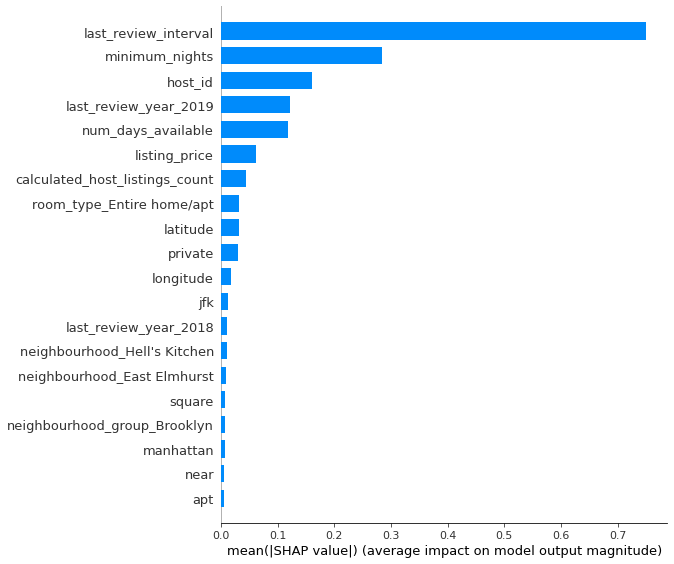

In [45]:
# Plot 1
shap.summary_plot(train_catboost_shap_values, X_train_enc, plot_type="bar")

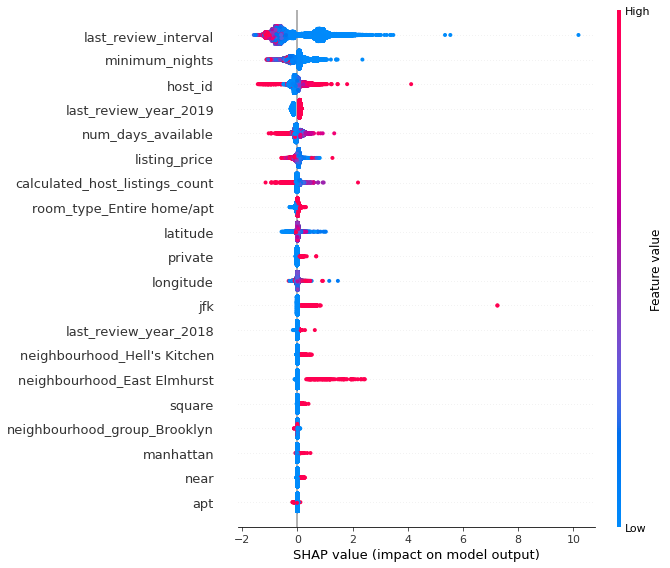

In [46]:
shap.summary_plot(train_catboost_shap_values, X_train_enc)

**Plot 1** : The first plot shows the average SHAP value for each feature. Based on the 1st plot generated we can say that the feature `last_review_interval` has highest average impact on the model's output (seems most important feature) and the feature `minimum_heights` has the second highest average impact on the model's output.

**Plot 2** : The second plot above shows the most important features for predicting the output and It also shows the direction of how the features are going to drive the prediction. As we can see above, this plot shows the relationship between the value of a feature and the impact on the prediction. Based on the plot, Few of the features mentioned below seem to be important and have significant impact on the predictions :

In the case of `last_review_interval`, we can see that high feature value would lead to a low SHAP value which means that high value of this feature are going to push the predictions to a smaller number. Also, we can see that low feature value would lead to a high SHAP value which means that low value of this feature are going to push the predictions to a bigger number.

In the case of `minimum_nights`, we can see that high values for this feature value lead to low SHAP values which means that high values of this feature are going to push the predictions to a smaller number and we can see that low values for this feature value lead to high SHAP values which means that low values of this feature are going to push the predictions to a bigger number.

Overall, `last_review_interval` seems to be the most important feature.

### Model Evaluation

In [47]:
# Best Performing model is the CatBoost Regressor

pipe_catboost.fit(X_train, y_train)
pipe_catboost.score(X_test, y_test)

0.5912181525282793

**Analysis**

The validation score we got above for the Catboost Regressor is around 0.574 and the test score we got above is 0.5905. Both the scores are quite close and have a small difference. It looks like the model does generalize well on unseen data but we cannot be certain that the model would perform similarly if the data is from a different region's Airbnb as the trends might differ from place to place. Optimization Bias occurs when our dataset is small and our validation set is hit too many times, we suffer from optimization bias or overfitting the validation set. It seems that the chance of optimization bias occuring is low as the size of test set is large.

### Results Summary

**Model Summary**

| Model | Type | Data set | R^2 Score | Performance |
| --- | --- | --- | --- | --- | 
| Ridge | Linear Model | Train Set |0.318 | Inadequate, Underfitting
| XGBoost Regressor | Non Linear Model | Train Set | 0.550 | Inadequate
| Random Forest Regressor | Non Linear Model | Train Set | 0.560 | Overfitting
| LGBM Regressor | Non Linear Model | Train Set | 0.567 | Comparable to Catboost but lower R^2
| CatBoost Regressor | Non Linear Model | Test Set | 0.590 | Best Model

**Features Summary**

|Feature Name (Order of Importance)| Feature Summary| 
| --- | --- |
| last_review_interval | represents the interval between last review date and end of 2019 | 
| minimum_nights | represents the min number of nights required to be eligible to stay in a listing| 
| host_id | represents the id of different hosts of listings |
| num_days_available | number of days in a year that a listing is usually available for|
| price | price of the listing |

As we can see above, the best performing model is a non linear model -  Catboost Regressor with a final test $R^2$ of 0.590 as it fits our data the best. Also, the top most important features for our prediction are `last_review_interval`, `minimum_nights`, `host_id`, `num_days_available` and `price`. We can see other model's performance in comparison to CatBoost Regressor and it seems that this model performs the best for our data. This model neither overfits nor underfits. We can look into further optimizing the performance of our Catboost Regressor by doing a thorough analysis of the best hyperparameters for the model. 

We have done some feature engineering on the data we had and the new feature that was engineered `last_review_interval` which represents the interval between last review date and end of 2019 happens to be the most important feature for our model.